<a href="https://colab.research.google.com/github/Sreeshbk/Machine_learning/blob/main/misc/Drift_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drift Monitoring


Monitoring models over time entails safeguarding against drift in model performance as well as breaking changes.  In this lesson, you explore solutions to drift and implement statistical methods for identifying drift.

The majority of machine learning solutions assume that data is generated according to a stationary probability distribution. However, because most datasets involving human activity change over time, machine learning solutions often go stale.

For example, a model trained to predict restaurant sales before the COVID-19 pandemic would likely not be an accurate model of restaurant sales during the pandemic. The distribution generating the data changed, or drifted, over time. 

Drift is composed of number of different types:
* **Data Drift**
 * **Data Changes**
 * In practice, upstream data changes is one of the most common sources of drift
 * For instance, null records from a changed ETL task
* **Feature Drift** 
 * Change in the distribution of an input feature(s)
 * Change in \\(P(X)\\)
* **Label Drift**
 * Change in the distribution of the label in the data
 * Change in  \\(P(Y)\\)
* **Prediction Drift** 
 * Change in the distribution of the predicted label given by the model
 * Change in \\(P(\hat{Y}| X)\\) 
* **Concept Drift** 
 * Change in the relationship between input variables and label
 * Change in distribution of \\(P(Y| X)\\)
 * Likely results in an invalid current model

**A rigorous monitoring solution for drift entails monitoring each cause of drift.**

 It is important to note that each situation will need to be handled differently and that the presence of drift does not immediately indicate a need to replace the current model. 

For example:

* Imagine a model designed to predict snow cone sales with temperature as an input variable. If more recent data has higher temperatures and higher snow cone sales, we have both feature and label drift, but as long as the model is performing well, then there is not an issue. However, we might still want to take other business action given the change, so it is important to monitor for this anyway. 
* However, if temperature rose and sales increased, but our predictions did not match this change, we could have concept drift and will need to retrain the model. 
* In either case, we may want to alert the company of the changes in case they impact other business processes, so it is important to track all potential drift. 

**In order to best adapt to possible changes, we compare data and predictions across time windows to identify any kind of drift that could be occuring.**


The essence of drift monitoring is **running statistical tests on time windows of data.** This allows us to detect drift and localize it to specific root causes. Here are some solutions:

**Numeric Features**

* Summary Statisitcs
  * Mean, Median, Variance, Missing value count, Max, Min
  * Tests  
    * <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence" target="_blank">Jensen-Shannon</a>
      - This method provides a smoothed and normalized metric
    * <a href="https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test" target="_blank">Two-Sample Kolmogorov-Smirnov (KS)</a>, <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test" target="_blank">Mann-Whitney</a>, or <a href="https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test" target="_blank">Wilcoxon tests</a>.
   <br>Note: These tests vary largely in their assumption of normalcy and ability to handle larger data sizes
      - Do a check of normalcy and choose the appropriate test based on this (e.g. Mann-Whitney is more permissive of skew) 
   * <a href="https://en.wikipedia.org/wiki/Wasserstein_metric" target="_blank">Wasserstein Distance</a>
     * <a href="https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence" target="_blank">Kullback–Leibler divergence</a>
        - This is related to Jensen-Shannon divergence

**Categorical Features**
 * Summary Statistics
   * Mode, Number of unique values, Number of missing values
 * Tests
   * <a href="https://en.wikipedia.org/wiki/Chi-squared_test" target="_blank">One-way Chi-Squared Test</a>
   * <a href="https://en.wikipedia.org/wiki/Chi-squared_test" target="_blank">Chi-Squared Contingency Test</a>
   * <a href="https://en.wikipedia.org/wiki/Fisher%27s_exact_test" target="_blank">Fisher's Exact Test</a>

We also might want to store the relationship between the input variables and label. In that case, we handle this differently depending on the label variable type. 

**Numeric Comparisons**
  * <a href="https://en.wikipedia.org/wiki/Pearson_correlation_coefficient" target="_blank">Pearson Coefficient</a>

**Categorical Comparisons** 
  * <a href="https://en.wikipedia.org/wiki/Contingency_table#:~:text=In%20statistics%2C%20a%20contingency%20table,frequency%20distribution%20of%20the%20variables.&text=They%20provide%20a%20basic%20picture,help%20find%20interactions%20between%20them." target="_blank">Contingency Tables</a>


One interesting alternative is to frame monitoring as a supervised learning problem where you use your features and label as inputs to a model and your label is whether a given row comes from the training or inference set. As the model's accuracy improves, it would imply that the model as drifted.

# Kolmogorov-Smirnov Test 
 Use the **Two-Sample Kolmogorov-Smirnov (KS) Test** for numeric features. This test determines whether or not two different samples come from the same distribution. This test:<br><br>
 - Returns a higher KS statistic when there is a higher probability of having two different distributions
 - Returns a lower P value the higher the statistical significance

In practice, we need a thershold for the p-value, where we will consider it ***unlikely enough*** that the samples did not come from the same distribution. Usually this threshold, or alpha level, is 0.05.

In [1]:
import seaborn as sns
from scipy.stats import gaussian_kde, truncnorm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import distance

In [2]:
def plot_distribution(distibution_1, distibution_2):
    """
    Plots the two given distributions 
    :param distribution_1: rv_continuous 
    :param distribution_2: rv_continuous 
    """
    sns.kdeplot(distibution_1, shade=True, color="g", label=1)
    sns.kdeplot(distibution_2, shade=True, color="b", label=2)
    plt.legend(loc="upper right", borderaxespad=0)

def get_truncated_normal(mean=0, sd=1, low=0.2, upp=0.8, n_size=1000, seed=999):
    """
    Generates truncated normal distribution based on given mean, standard deviation, lower bound, upper bound and sample size 
    :param mean: float, mean used to create the distribution 
    :param sd: float, standard deviation used to create distribution
    :param low: float, lower bound used to create the distribution 
    :param upp: float, upper bound used to create the distribution 
    :param n_size: integer, desired sample size 
    :return distb: rv_continuous 
    """
    np.random.seed(seed=seed)

    a = (low-mean) / sd
    b = (upp-mean) / sd
    distb = truncnorm(a, b, loc=mean, scale=sd).rvs(n_size, random_state=seed)
    return distb

def calculate_ks(distibution_1, distibution_2):
    """
    Helper function that calculated the KS stat and plots the two distributions used in the calculation 
    :param distribution_1: rv_continuous
    :param distribution_2: rv_continuous 
    :return p_value: float, resulting p-value from KS calculation
    :return ks_drift: bool, detection of significant difference across the distributions 
    """
    base, comp = distibution_1, distibution_2
    p_value = np.round(stats.ks_2samp(base, comp)[1],3)
    ks_drift = p_value < 0.05

    # Generate plots
    plot_distribution(base, comp)
    label = f"KS Stat suggests model drift: {ks_drift} \n P-value = {p_value}"
    plt.title(label, loc="center")
    return p_value, ks_drift

def calculate_probability_vector(distibution_1, distibution_2):
    """
    Helper function that turns raw values into a probability vector 
    :param distribution_1: rv_continuous
    :param distribution_2: rv_continuous 
    :return p: array, probability vector of distribution_1
    :return q: array, probability vector of distribution_2
    """
    global_min = min(min(distibution_1), min(distibution_2))
    global_max = max(max(distibution_1), max(distibution_2))
    
    p = np.histogram(distibution_1, bins=20, range=(global_min, global_max))
    q = np.histogram(distibution_2, bins=20, range=(global_min, global_max))
    
    return p[0], q[0]
    
def calculate_js_distance(p, q, raw_distribution_1, raw_distribution_2, threshold=0.2):
    """
    Helper function that calculated the JS distance and plots the two distributions used in the calculation 
    :param p: array, probability vector for the first distribution
    :param q: array, probability vector for the second distribution 
    :param raw_distribution_1: array, raw values used in plotting
    :param raw_distribution_2: array, raw values used in plotting
    :param threshold: float, cutoff threshold for the JS statistic
    :return js_stat: float, resulting distance measure from JS calculation
    :return js_drift: bool, detection of significant difference across the distributions 
    """
    js_stat = distance.jensenshannon(p, q, base=2)
    js_stat_rounded = np.round(js_stat, 3)
    js_drift = js_stat > threshold

    # Generate plot
    plot_distribution(raw_distribution_1, raw_distribution_2)
    label = f"Jensen Shannon suggests model drift: {js_drift} \n JS Distance = {js_stat_rounded}"
    plt.title(label, loc="center")

    return js_stat, js_drift

Let's start with a sample size of 50.

(1.0, False)

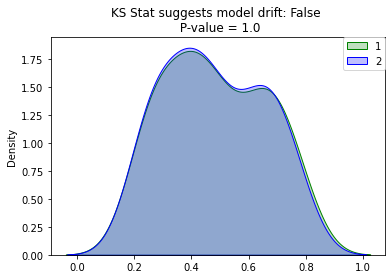

In [3]:
calculate_ks(
  get_truncated_normal(upp=.80, n_size=50), 
  get_truncated_normal(upp=.79, n_size=50) 
)

Great! We can see the distributions look pretty similar and we have a high p-value. Now, let's increase the sample size and see its impact on the p-value...Let's set **`N = 1,000`**


(0.0, True)

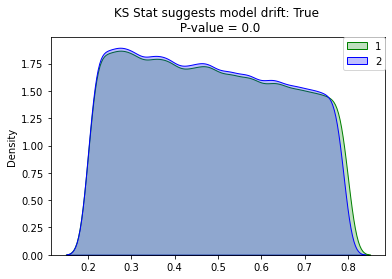

In [4]:
calculate_ks(
  get_truncated_normal(upp=.80, n_size=100000), 
  get_truncated_normal(upp=.79, n_size=100000) 
)

 With the increased sample size, our **`ks_stat`** has dropped to near zero indicating that our two samples are significantly different. However, by just visually looking at the plot of our two overlapping distributions, they look pretty similar. Caculating the **`ks_stat`** can be useful when determining the similarity between two distributions, however you can quickly run into limitations based on sample size. So how can we test for distribution similarity when we have a *large sample size*?


## Jensen Shannon

Jensen Shannon (JS) distance is more appropriate for drift detection on a large dataset since it **meaures the distance between two probability distributions and it is smoothed and normalized.** When log base 2 is used for the distance calculation, the JS statistic is bounded between 0 and 1:
 - 0 means the distributions are identical
 - 1 means the distributions have no similarity

The JS distance is defined as the square root of the <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence" target="_blank">JS </a>

![Jensen Shannon Divergence](https://miro.medium.com/max/1400/1*viATYZeg9SiT-ZdzYGjKYA.png)

 where *M* is defined as the pointwise mean of *P* and *Q* and *H(P)* is defined as the entropy function:

![JS Entropy](https://miro.medium.com/max/1400/1*NSIn8OVTKufpSlvOOoXWQg.png)

Unlike the KS statistic that provides a p value, the JS statistic only provides a scalar value. You therefore need to **manually provide a cutoff threshold** above which you will count the two datasets as having drifted.

Verify a JS statistic of 0 with two identical distributions. Note that the **`p`** and **`q`** arguments here are probability vectors, not raw values

In [5]:
distance.jensenshannon(p=[1.0, 0.0, 1.0], q=[1.0, 0.0, 1.0], base=2.0)

0.0

(0.04147735123124928, False)

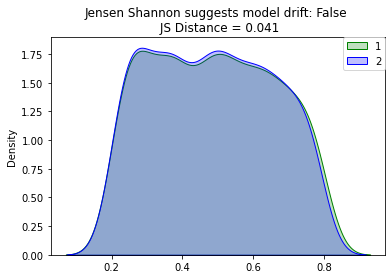

In [6]:
raw_distribution_1 = get_truncated_normal(upp=.80, n_size=1000)
raw_distribution_2 = get_truncated_normal(upp=.79, n_size=1000)

p, q = calculate_probability_vector(raw_distribution_1, raw_distribution_2)

calculate_js_distance(p, q, raw_distribution_1, raw_distribution_2, threshold=0.2) 

(0.03279199904482657, False)

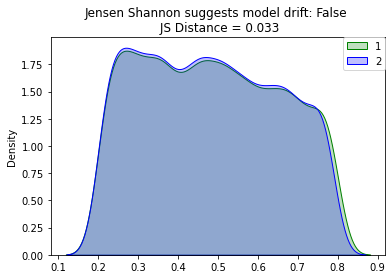

In [7]:
raw_distribution_1 = get_truncated_normal(upp=.80, n_size=10000)
raw_distribution_2 = get_truncated_normal(upp=.79, n_size=10000)

p, q = calculate_probability_vector(raw_distribution_1, raw_distribution_2)

calculate_js_distance(p, q, raw_distribution_1, raw_distribution_2, threshold=0.2) 

(0.03177292121031257, False)

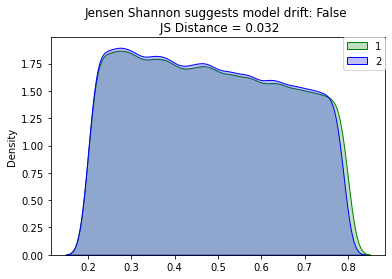

In [8]:
raw_distribution_1 = get_truncated_normal(upp=.80, n_size=100000)
raw_distribution_2 = get_truncated_normal(upp=.79, n_size=100000)

p, q = calculate_probability_vector(raw_distribution_1, raw_distribution_2)

calculate_js_distance(p, q, raw_distribution_1, raw_distribution_2, threshold=0.2) 

As illustrated above, the JS distance is much more resilient to increased sample size because it is smoothed and normalized.

 In practice, you would have data over a period of time, divide it into groups based on time (e.g. weekly windows), and then run the tests on the two groups to determine if there was a statistically significant change. The frequency of these monitoring jobs depends on the training window, inference data sample size, and use case. We'll simulate this with our datase

In [9]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/xirohxytyn2omyvl6xg6wxmu3mcdjx')
df['price'] = df["price"].str[1:].str.replace(",","").astype("float")

In [10]:
# Identify Numeric & Categorical Columns
num_cols = ["accommodates", "bedrooms", "beds", "minimum_nights", "number_of_reviews", "review_scores_rating", "price"]
cat_cols = ["neighbourhood_cleansed", "property_type", "room_type"]

# Drop extraneous columns for this example
airbnb_pdf = df[num_cols + cat_cols]

# Split Dataset into the two groups
pdf1 = airbnb_pdf.sample(frac = 0.5, random_state=1)
pdf2 = airbnb_pdf.drop(pdf1.index)

Alter **`pdf2`** to simulate drift. Add the following realistic changes: 
 * ***The demand for Airbnbs skyrockted, so the prices of Airbnbs doubled***.
 * *Type of Drift*: Concept, Label 
  * ***An upstream data management error resulted in null values for `neighbourhood_cleansed`***
 * *Type of Drift*: Feature
  * ***An upstream data change resulted in `review_score_rating` move to a 5 star rating system, instead of the previous 100 point system. ***
 * *Type of Drift*: Feature

In [11]:

pdf2["price"] = 2 * pdf2["price"]
pdf2["review_scores_rating"] = pdf2["review_scores_rating"] / 20
pdf2["neighbourhood_cleansed"] = pdf2["neighbourhood_cleansed"].map(lambda x: None if x == 0 else x)

In [12]:
pdf1.describe()

,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,price
count,3788.000000,3788.000000,3784.000000,3788.000000,3788.000000,3044.000000,3788.000000
mean,3.213305,1.346357,1.788584,16.399155,43.587909,95.646189,215.544615
std,1.907115,0.931731,1.166416,28.485096,73.191235,7.084531,263.698161
min,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.000000
25%,2.000000,1.000000,1.000000,2.000000,1.000000,95.000000,100.000000
50%,2.000000,1.000000,1.000000,4.000000,12.000000,98.000000,150.000000
75%,4.000000,2.000000,2.000000,30.000000,55.000000,100.000000,249.000000
max,16.000000,7.000000,9.000000,999.000000,712.000000,100.000000,8000.000000


In [13]:
pdf2.describe()

,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,price
count,3787.000000,3785.000000,3784.000000,3.787000e+03,3787.000000,2994.000000,3787.000000
mean,3.214682,1.357992,1.780920,2.642255e+04,44.950621,4.781430,429.716398
std,1.950555,0.942299,1.202406,1.624996e+06,76.357449,0.344259,497.569748
min,1.000000,0.000000,0.000000,1.000000e+00,0.000000,1.000000,38.000000
25%,2.000000,1.000000,1.000000,2.000000e+00,1.000000,4.750000,200.000000
50%,2.000000,1.000000,1.000000,4.000000e+00,11.000000,4.900000,310.000000
75%,4.000000,2.000000,2.000000,3.000000e+01,54.000000,5.000000,490.000000
max,16.000000,14.000000,14.000000,1.000000e+08,672.000000,5.000000,10000.000000


In [14]:
cm = sns.light_palette("#2ecc71", as_cmap=True)
summary1_pdf = pdf1.describe()[num_cols]
summary2_pdf = pdf2.describe()[num_cols]
percent_change = 100 * abs((summary1_pdf - summary2_pdf) / (summary1_pdf + 1e-100))
percent_change.style.background_gradient(cmap=cm, text_color_threshold=0.5, axis=1)

,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,price
count,0.026399,0.079197,0.000000,0.026399,0.026399,1.642576,0.026399
mean,0.042842,0.864196,0.428487,161021.399788,3.126352,95.000920,99.363087
std,2.277801,1.134297,3.085523,5704623.312324,4.325947,95.140700,88.689123
min,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,37999999999999996889926940235282902181759906696423919780887168451751022700782120610306192633897248882688.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,100.000000
50%,0.000000,0.000000,0.000000,0.000000,8.333333,95.000000,106.666667
75%,0.000000,0.000000,0.000000,0.000000,1.818182,95.000000,96.787149
max,0.000000,100.000000,55.555556,10009910.010010,5.617978,95.000000,25.000000


 The **`review_scores_rating`** and **`price`** seem to have many of their stats changed significantly, so we would want to look into those. Now run the KS test on the two subsets of the data. However, we cannot use the default alpha level of 0.05 in this situation because we are running a group of tests. This is because the probability of at least one false positive (concluding the feature's distribution changed when it did not) in a group of tests increases with the number of tests in the group. 

To solve this problem we will employ the **Bonferroni Correction**. This changes the alpha level to 0.05 / number of tests in group. It is common practice and reduces the probability of false positives. 

 More information can be found <a href="https://en.wikipedia.org/wiki/Bonferroni_correction" target="_blank">here</a>.

In [15]:
# Set the Bonferroni Corrected alpha level
alpha = 0.05
alpha_corrected = alpha / len(num_cols)

# Loop over all numeric attributes (numeric cols and target col, price)
for num in num_cols:
    # Run test comparing old and new for that attribute
    ks_stat, ks_pval = stats.ks_2samp(pdf1[num], pdf2[num], mode="asymp")
    if ks_pval <= alpha_corrected:
        print(f"{num} had statistically significant change between the two samples")

review_scores_rating had statistically significant change between the two samples
price had statistically significant change between the two samples


In [16]:
# Set the JS stat threshold
threshold = 0.2

# Loop over all numeric attributes (numeric cols and target col, price)
for num in num_cols:
    # Run test comparing old and new for that attribute
    range_min = min(pdf1[num].min(), pdf2[num].min())
    range_max = max(pdf1[num].max(), pdf2[num].max())
    base = np.histogram(pdf1[num], bins=20, range=(range_min, range_max))
    comp = np.histogram(pdf2[num], bins=20, range=(range_min, range_max))
    js_stat = distance.jensenshannon(base[0], comp[0], base=2)
    if js_stat >= threshold:
        print(f"{num} had statistically significant change between the two samples")

review_scores_rating had statistically significant change between the two samples
price had statistically significant change between the two samples


In [17]:
pd.concat(
  [100 * pdf1.isnull().sum() / len(pdf1), 100 * pdf2.isnull().sum() / len(pdf2)], 
  axis=1, 
  keys=["pdf1", "pdf2"]
).style.background_gradient(cmap=cm, text_color_threshold=0.5, axis=1)

,pdf1,pdf2
accommodates,0.000000,0.000000
bedrooms,0.000000,0.052812
beds,0.105597,0.079218
minimum_nights,0.000000,0.000000
number_of_reviews,0.000000,0.000000
review_scores_rating,19.640971,20.940058
price,0.000000,0.000000
neighbourhood_cleansed,0.000000,0.000000
property_type,0.000000,0.000000
room_type,0.000000,0.000000


In [18]:

alpha = 0.05
corrected_alpha = alpha / len(cat_cols) # Still using the same correction
    
for feature in cat_cols:
    pdf_count1 = pd.DataFrame(pdf1[feature].value_counts()).sort_index().rename(columns={feature:"pdf1"})
    pdf_count2 = pd.DataFrame(pdf2[feature].value_counts()).sort_index().rename(columns={feature:"pdf2"})
    pdf_counts = pdf_count1.join(pdf_count2, how="outer").fillna(0)
    obs = np.array([pdf_counts["pdf1"], pdf_counts["pdf2"]])
    _, p, _, _ = stats.chi2_contingency(obs)
    if p < corrected_alpha:
        print(f"{feature} statistically significantly changed")
    else:
        print(f"{feature} did not statistically significantly change")


neighbourhood_cleansed did not statistically significantly change
property_type did not statistically significantly change
room_type did not statistically significantly change


**Note:** The Two-way Chi-Squared test caught this not because nulls were introduced, but because they were introduced into one neighbourhood specifically, leading to an uneven distribution. If nulls were uniform throughout, then the test would see a similar distribution, just with lower counts, which this test would not flag as a change in dependence.

Optional Note on Chi-Squared tests.

For the Chi-Squared tests, distributions with low bin counts can invalidate the test's accuracy and lead to false positives.  

There are also two types of Chi-Squared tests: One-way and Two-way (or contingency) tests. One-way testing is a goodness of fit test. It takes a single feature distribution and a population distribution and reports the probabilty of randomly drawing the single feature distribution from that population. In the context of drift monitoring, you would use the old time window as the population distribution and the new time window as the single feature distribution. If the p-value was low, then it would be likely that drift occured and that the new data no longer resembles the old distribution. This test compares counts, so if a more recent time window has a similar distribution but less data in it, this will return a low p-value when it perhaps should not. In that situation, try the Two-way test. 

The Two-way or contingency test used above is rather a test for independence. It takes in a table where the rows represent time window 1 and 2 and the columns represent feature counts for a given feature. It determines whether or not there is a relationship between the time window and the feature distributions, or, in other words, if the distributions are independent of the time window. It is important to note that this test will not catch differences such as a decrease in total counts in the distribution. This makes it useful when comparing time windows with unequal amounts of data, but make sure to check for changes in null counts or differences in counts separately that you might care about. 

Both of these assume high bin counts (generally >5) for each category in order to work properly. In our example, because of the large number of categories, some bin counts were lower than we would want for these tests. Fortunately, the scipy implementation of the Two-way test utilizes a correction for low counts that makes the Two-way preferable to the One-way in this situation, although ideally we would still want higher bin counts. 

The Fisher Exact test is a good alternative in the situation where the counts are too low, however there is currently no Python implemenation for this test in a contingency table larger than 2x2. If you are looking to run this test, you should explore using R. 

These are subtle differences that are worth taking into account, but in either case, a low p-value would indicate significantly different distributions across the time window and therefore drift for the One-Way or Two-way Chi-Squared.

In [19]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np 
from scipy.spatial import distance

class Monitor():
  
    def __init__(self, pdf1, pdf2, cat_cols, num_cols, alpha=.05, js_stat_threshold=0.2):
        """
        Pass in two pandas dataframes with the same columns for two time windows
        List the categorical and numeric columns, and optionally provide an alpha level
        """
        assert (pdf1.columns == pdf2.columns).all(), "Columns do not match"
        self.pdf1 = pdf1
        self.pdf2 = pdf2
        self.categorical_columns = cat_cols
        self.continuous_columns = num_cols
        self.alpha = alpha
        self.js_stat_threshold = js_stat_threshold
    
    def run(self):
        """
        Call to run drift monitoring
        """
        self.handle_numeric_js()
        self.handle_categorical()
        
        pdf1_nulls = self.pdf1.isnull().sum().sum()
        pdf2_nulls = self.pdf2.isnull().sum().sum()
        print(f"{pdf1_nulls} total null values found in pdf1 and {pdf2_nulls} in pdf2")
        
  
    def handle_numeric_ks(self):
        """
        Handle the numeric features with the Two-Sample Kolmogorov-Smirnov (KS) Test with Bonferroni Correction 
        """
        corrected_alpha = self.alpha / len(self.continuous_columns)

        for num in self.continuous_columns:
            ks_stat, ks_pval = stats.ks_2samp(self.pdf1[num], self.pdf2[num], mode="asymp")
            if ks_pval <= corrected_alpha:
                self.on_drift(num)
                
    def handle_numeric_js(self):
        """
        Handles the numeric features with the Jensen Shannon (JS) test using the threshold attribute
        """
        for num in self.continuous_columns:
            # Run test comparing old and new for that attribute
            range_min = min(self.pdf1[num].min(), self.pdf2[num].min())
            range_max = max(self.pdf1[num].max(), self.pdf2[num].max())
            base = np.histogram(self.pdf1[num], bins=20, range=(range_min, range_max))
            comp = np.histogram(self.pdf2[num], bins=20, range=(range_min, range_max))
            js_stat = distance.jensenshannon(base[0], comp[0], base=2)
            if js_stat >= self.js_stat_threshold:
                self.on_drift(num)
      
    def handle_categorical(self):
        """
        Handle the Categorical features with Two-Way Chi-Squared Test with Bonferroni Correction
        Note: null counts can skew the results of the Chi-Squared Test so they're currently dropped
            by `.value_counts()`
        """
        corrected_alpha = self.alpha / len(self.categorical_columns)

        for feature in self.categorical_columns:
            pdf_count1 = pd.DataFrame(self.pdf1[feature].value_counts()).sort_index().rename(columns={feature:"pdf1"})
            pdf_count2 = pd.DataFrame(self.pdf2[feature].value_counts()).sort_index().rename(columns={feature:"pdf2"})
            pdf_counts = pdf_count1.join(pdf_count2, how="outer")#.fillna(0)
            obs = np.array([pdf_counts["pdf1"], pdf_counts["pdf2"]])
            _, p, _, _ = stats.chi2_contingency(obs)
            if p < corrected_alpha:
                self.on_drift(feature)

    def generate_null_counts(self, palette="#2ecc71"):
        """
        Generate the visualization of percent null counts of all features
        Optionally provide a color palette for the visual
        """
        cm = sns.light_palette(palette, as_cmap=True)
        return pd.concat([100 * self.pdf1.isnull().sum() / len(self.pdf1), 
                          100 * self.pdf2.isnull().sum() / len(self.pdf2)], axis=1, 
                          keys=["pdf1", "pdf2"]).style.background_gradient(cmap=cm, text_color_threshold=0.5, axis=1)
    
    def generate_percent_change(self, palette="#2ecc71"):
        """
        Generate visualization of percent change in summary statistics of numeric features
        Optionally provide a color palette for the visual
        """
        cm = sns.light_palette(palette, as_cmap=True)
        summary1_pdf = self.pdf1.describe()[self.continuous_columns]
        summary2_pdf = self.pdf2.describe()[self.continuous_columns]
        percent_change = 100 * abs((summary1_pdf - summary2_pdf) / (summary1_pdf + 1e-100))
        return percent_change.style.background_gradient(cmap=cm, text_color_threshold=0.5, axis=1)
  
    def on_drift(self, feature):
        """
        Complete this method with your response to drift.  Options include:
          - raise an alert
          - automatically retrain model
        """
        print(f"Drift found in {feature}!")
    
drift_monitor = Monitor(pdf1, pdf2, cat_cols, num_cols)
drift_monitor.run()

# COMMAND ----------

drift_monitor.generate_percent_change()

# COMMAND ----------

drift_monitor.generate_null_counts()

Drift found in review_scores_rating!
Drift found in price!
748 total null values found in pdf1 and 798 in pdf2


,pdf1,pdf2
accommodates,0.000000,0.000000
bedrooms,0.000000,0.052812
beds,0.105597,0.079218
minimum_nights,0.000000,0.000000
number_of_reviews,0.000000,0.000000
review_scores_rating,19.640971,20.940058
price,0.000000,0.000000
neighbourhood_cleansed,0.000000,0.000000
property_type,0.000000,0.000000
room_type,0.000000,0.000000


%md <i18n value="7dd9c6a3-8b89-46f4-a041-790fe2895ffc"/>



## Drift Monitoring Architecture

A potential workflow for deployment and dirft monitoring could look something like this:

![Azure ML Pipeline](https://files.training.databricks.com/images/monitoring.png)

**Workflow**
* ***Deploy a model to production, using MLflow and Delta to log the model and data***
* ***When the next time step of data arrives:***
  * Get the logged input data from the current production model
  * Get the observed (true) values
  * Compare the evaluation metric (e.g. RMSE) between the observed values and predicted values
  * Run the statistical tests shown above to identify potential drift
* ***If drift is not found:***
  * Keep monitoring but leave original model deployed
* ***If drift is found:***
  * Analyze the situation and take action
  * If retraining/deploying an updated model is needed:
    * Create a candidate model on the new data
    * Deploy candidate model as long as it performs better than the current model on the more recent data




In this lesson, we focused on statistical methods for identifying drift. 

However, there are other methods.

<a href="https://scikit-multiflow.github.io/" target="_blank">The package `skmultiflow`</a> has some good options for drift detection algorithms. Try the DDM method.


<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/drift.png" style="height: 400px; margin: 20px"/></div>

The detection threshold is calculated as a function of two statistics, obtained when `(pi + si)` is minimum:

 * `pmin`: The minimum recorded error rate
 * `smin`: The minimum recorded standard deviation

At instant `i`, the detection algorithm uses:

 * `pi`: The error rate at instant i
 * `si`: The standard deviation at instant i

The default conditions for entering the warning zone and detecting change are as follows:

 * if `pi + si >= pmin + 2 * smin` -> Warning zone
 * if `pi + si >= pmin + 3 * smin` -> Change detected

#### Model Based Approaches

A much less intuitive but possibly more powerful approach would focus on a machine learning based solution. 

Some common examples: 

1. Create a supervised approach on a dataset of data classified as normal or abnormal. Finding such a dataset can be difficult, however. 
2. Use a regression method to predict future values for incoming data over time and detect drift if there is strong prediction error.

